In [17]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

c:\Users\Diego\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [21]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

#cat_vars = ['Store', 'DayOfWeek']

In [22]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
#contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [23]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [24]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


# Asignación de dimensión de embeddings

In [25]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [26]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 2 4 [0 1 2 3]

CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 1 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

# Definición de modelo

In [27]:
add_customers = True
log_output = False
output_activation = 'linear'

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [29]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [30]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [31]:
# Descomentar para ver resultados
#cat_vars_embed_outs
#cat_var_inputs
#cont_vars_inputs
#cont_vars_outs

In [32]:
first_hidden_units = 1000
second_hidden_units = 1000
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [33]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [34]:
# Descomentar para ver
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                              

In [35]:
model.save_weights('initial_weights.hdf5')

In [36]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [37]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [38]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [39]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\Diego\AppData\Local\Temp\ipykernel_5700\3553976367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
C:\Users\Diego\AppData\Local\Temp\ipykernel_5700\3553976367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
C:\Users\Diego\AppData\Local\Temp\ipykernel_5700\3553976367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [40]:
from tensorflow.keras import backend as K

In [41]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [42]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [43]:
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [44]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [45]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std
#    y_max = df_train[y_out_columns].max().values
#    y_train = df_train[y_out_columns].values/y_max
#    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [46]:
lr = 0.001
model.compile(optimizer=Adam(learning_rate=lr), metrics=['mse', rmspe], loss='mse')

In [47]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [48]:
epochs = 10
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/10

Epoch 1: val_Sales_mse improved from inf to 0.10708, saving model to bestmodel.hdf5
3181/3181 - 358s - loss: 0.2827 - Sales_loss: 0.1258 - Customers_loss: 0.0903 - Sales_mse: 0.1258 - Sales_rmspe: 26.8847 - Customers_mse: 0.0903 - Customers_rmspe: 10.1463 - val_loss: 0.2029 - val_Sales_loss: 0.1071 - val_Customers_loss: 0.0668 - val_Sales_mse: 0.1071 - val_Sales_rmspe: 33.9335 - val_Customers_mse: 0.0668 - val_Customers_rmspe: 9.8241 - 358s/epoch - 113ms/step
Epoch 2/10

Epoch 2: val_Sales_mse did not improve from 0.10708
3181/3181 - 331s - loss: 0.1435 - Sales_loss: 0.0731 - Customers_loss: 0.0457 - Sales_mse: 0.0731 - Sales_rmspe: 22.5689 - Customers_mse: 0.0457 - Customers_rmspe: 8.0026 - val_loss: 0.1900 - val_Sales_loss: 0.1098 - val_Customers_loss: 0.0586 - val_Sales_mse: 0.1098 - val_Sales_rmspe: 31.4101 - val_Customers_mse: 0.0586 - val_Customers_rmspe: 9.2803 - 331s/epoch - 104ms/step
Epoch 3/10

Epoch 3: val_Sales_mse improved from 0.10708 to 0.08506, saving model

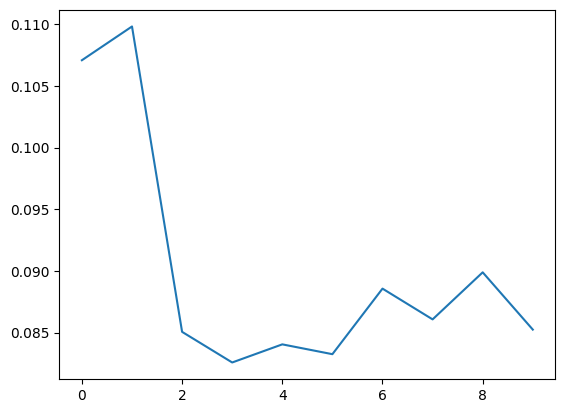

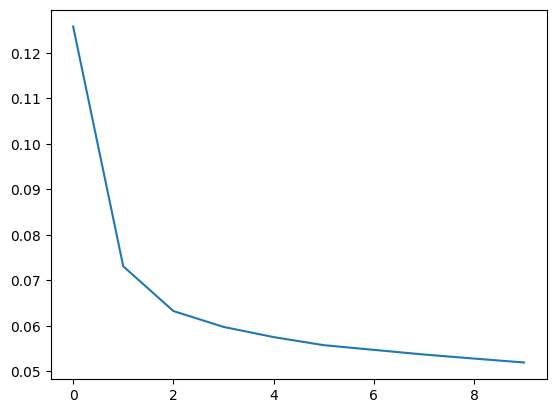

In [49]:
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
#plt.plot(history.history['loss'])
#plt.plot(history.history['Customers_mse'])
plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [50]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 14s 15ms/step - loss: 0.1463 - Sales_loss: 0.0852 - Customers_loss: 0.0477 - Sales_mse: 0.0852 - Sales_rmspe: 11.9979 - Customers_mse: 0.0477 - Customers_rmspe: 4.7259


[0.14634130895137787,
 0.08524241298437119,
 0.047712475061416626,
 0.08524241298437119,
 11.9978666305542,
 0.047712475061416626,
 4.725880146026611]

In [51]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 14s 15ms/step - loss: 0.1457 - Sales_loss: 0.0826 - Customers_loss: 0.0465 - Sales_mse: 0.0826 - Sales_rmspe: 11.0802 - Customers_mse: 0.0465 - Customers_rmspe: 4.4107


[0.1457476168870926,
 0.08257733285427094,
 0.0464678592979908,
 0.08257733285427094,
 11.080225944519043,
 0.0464678592979908,
 4.41074275970459]

In [52]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [53]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        #y_pred = model.predict(X_val, verbose=1)[0]*y_max
        #y_pred_test = model.predict(X_test, verbose=1)[0]*y_max
   
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 16s 13ms/step


In [54]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.13124923817493256

In [55]:
y_pred_test[:10]

array([4663.1494, 7167.4673, 8634.65  , 6600.0513, 7583.2256, 5976.4883,
       7329.151 , 7813.914 , 5302.742 , 5837.0234], dtype=float32)

# Baseline

In [56]:
import pandas as pd
sample_csv = pd.read_csv('rossmann/sample_submission.csv')

In [57]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [58]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [59]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [60]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [61]:
sample_csv['Sales'] = df_test['Sales']

In [62]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [63]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Submit a la competición

In [64]:

sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [65]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [72]:
year_embed = model.get_layer('Year_Embed').get_weights()
#a = model.get_layer('Year_Embed').get_weights()[1]

In [73]:
year_e

[array([[ 0.44370422,  0.39437225],
        [-0.44687515,  0.01833746],
        [-0.46640238, -0.9648156 ]], dtype=float32)]

(7, 2)


Text(0.5, 1.0, 'DayOfWeek_embed')

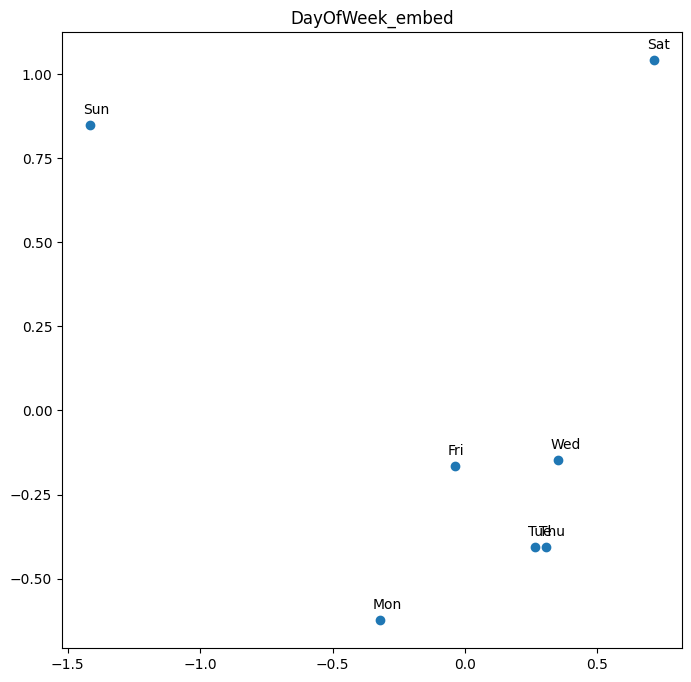

In [74]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])
plt.title('DayOfWeek_embed')

(1115, 50)


Text(0.5, 1.0, 'Store_embed')

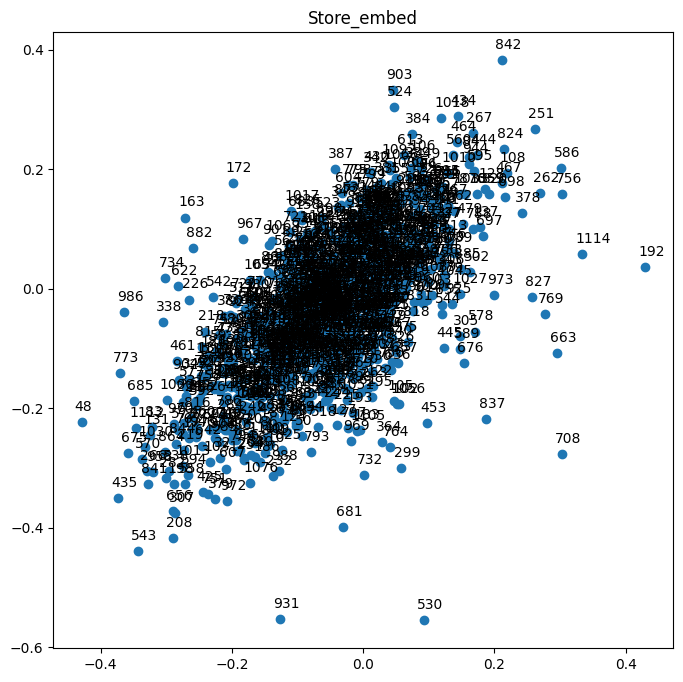

In [97]:
stores = list(np.linspace(1,1115,1115))
for i in range(len(stores)):
    stores[i]=str(int(stores[i]))

plot_embed('Store_Embed', stores)
plt.title('Store_embed')

(12, 2)


Text(0.5, 1.0, 'Month_embed')

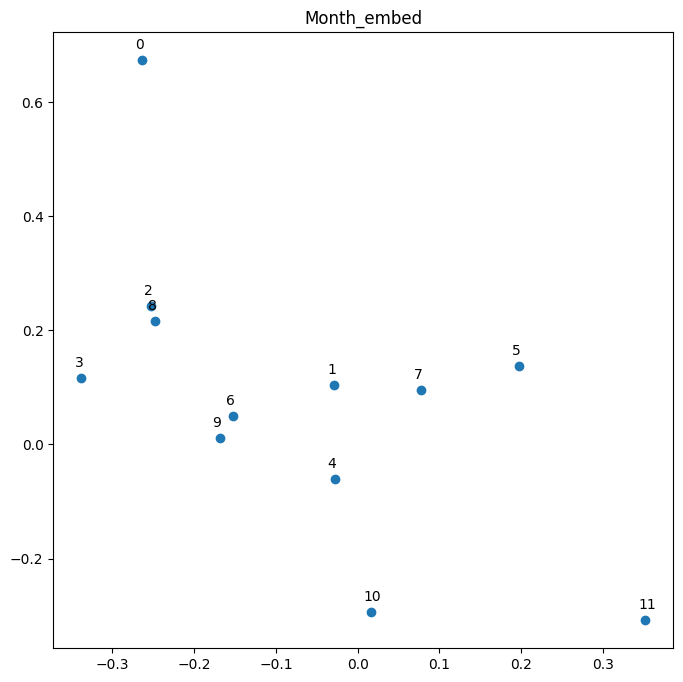

In [99]:
plot_embed('Month_Embed', list(range(12)))
plt.title('Month_embed')

(4, 2)


Text(0.5, 1.0, 'StateHoliday_Embed')

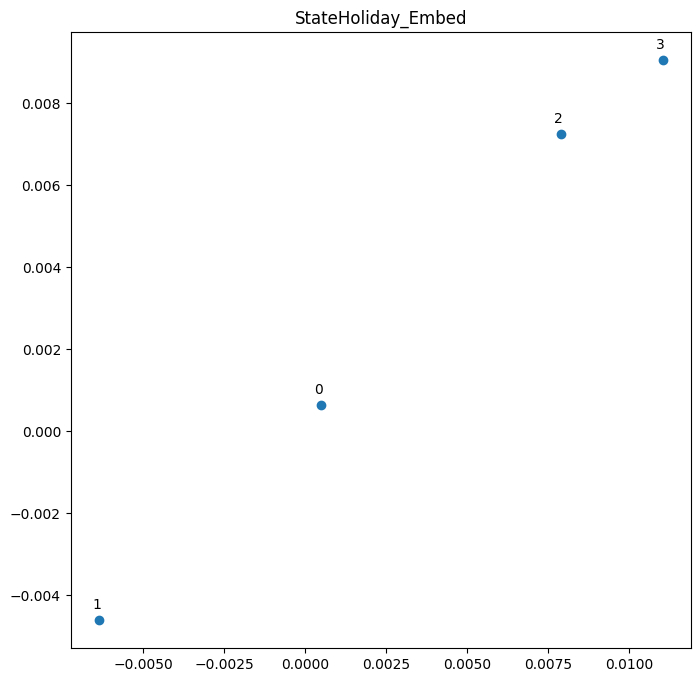

In [107]:
plot_embed('StateHoliday_Embed',list(df['StateHoliday'].unique()))
plt.title('StateHoliday_Embed')

(25, 2)


Text(0.5, 1.0, 'CompetitionMonthsOpen_Embed')

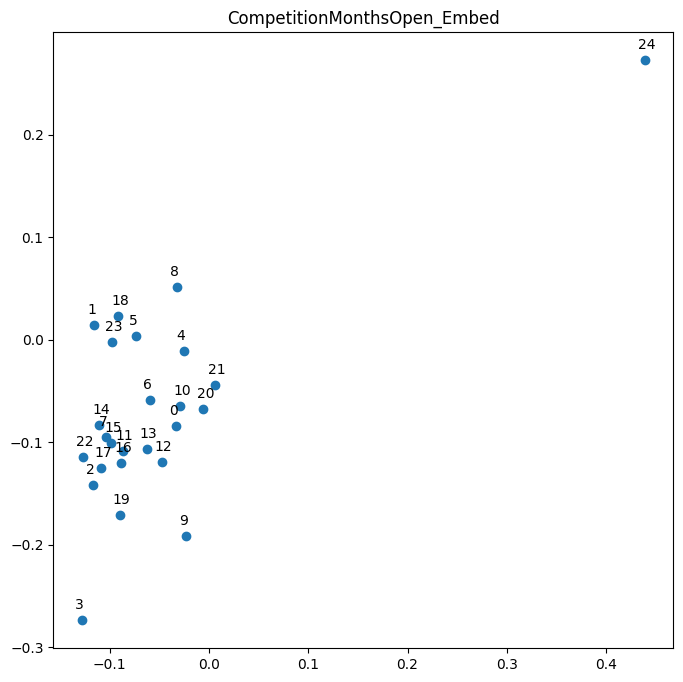

In [114]:
plot_embed('CompetitionMonthsOpen_Embed',list(df['CompetitionMonthsOpen'].unique()))
plt.title('CompetitionMonthsOpen_Embed')

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Store embeddings

In [115]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [116]:
submodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [117]:
submodel.save('embeddings_model.hdf5')

# Respuestas

### Procesamiento de los datos

Los datos presentes son:

* train: información diaria de las tiendas, si esta abierta o cerrada, si hay feriado escolar o estatal, etc.
* store: tipo de tienda, información de la competencia, etc.
* store_states: relaciona cada tienda con el estado en que se encuentra
* state_names: códigos de identificación para cada estado
* google_trend: información de google trend para una semana particular
* weather: información climatológica

En cuanto al procesamiento, este comienza con la eliminación de datos faltantes. Hay un tratamiento distinto para cada variable, por ejemplo si no está la competencia se asume que no hay, o si no hay información sobre la promo 2 se asume que esta arranco en la semana cero. Otro ejemplo es con las fechas faltantes o las anteriores a 1990, las cuales se reemplazaron por Enero de 1990.
Luego del tratamiento de los datos faltantes, se unen los dataframes utilizando columnas en común entre los mismos, de forma de obtener un dataframe de entrenamiento completo. Por ejemplo, se unen los dataframes _train_ y _store_ usando la columna en común "Store". Analogamente se unen los dataframes del clima, google trend y store_states, luego de una transformación de las fechas.

Luego se agregan variables del tipo "antes" y "después" de eventos, como BeforeSchoolHoliday y AfterSchoolHoliday, la cual cuenta la cantidad de días hasta el proximo feriado escolar y luego desde el último. Lo mismo por ejemplo para BeforeStateHoliday y AfterStateHoliday. Posteriormente se realiza un suavizado temporal.

Luego de tener la totalidad de las variables y todas estas unidas en el dataframe de train, se realiza una normalización de las variables continuas y un labelencode de las categoricas, mediante StandardScaler() y LabelEncoder(), respectivamente. La función LabelEncoder() le asigna valores enteros a cada valor de una variable categórica, mientras que StandardScaler() estandariza las continuas. Para cada variable categórica luego se realiza un entity embedding, de forma de obtener una representación continua de cada variable.

### ¿Que son los entity embeddings y como se relacionan con las variables categóricas?

Los entity embeddings son representaciones en el plano continuuo de variables categoricas. Los entity embedding se consiguen
mediante el entrenamiento de una red que contiene capas de embedding, del cual se extraerán los mismos. Entre las ventajas de 
utilizar entity embeddings se encuentran el ahorro de espacio y aumento en la velocidad, comparado con el uso de one hot 
encodings.

Se relacionan con las variables categoricas a través de cada capa de embedding (embedding layer) de la red neuronal de embedding.
Cada variable categorica tendrá su capa de embedding, y la dimensión de la misma representa la dimensión del vector continuo que
representará dicha variable categórica.

### Modelos probados

Se probó con diferentes modelos, tanto con modelos MLP con embeddings (notebook 06-full-model) como con modelos de lightGBM (notebook 07-lightGBM), y con distintas combinaciones de parámetros. En la siguiente tabla se resumen los resultados conseguidos con cada modelo con que se probó.

<img src="scores.png">

Se puede ver que los mejores resultados con MLP se consiguieron utilizando un _learning rate_=0.05, _batch size_=256, Lambda_L2=0.01, N1=1000, N2=1000, con un score de 0.12890. Sin embargo, se obtuvieron mejores resultados con uno de los modelos de lightGBM, con _learning rate_=0.05, _min child samples_=4 y _n iterations_=4000, con el cual se obtuvo el score de 0.11468. A continuación se muestra una captura de pantalla con dicho resultado.

<img src="screen_score_rossmann_2.png">
<img src="screen_score_rossmann.png">

    ¿Qué es lightGBM?

LightGBM es un tipo de modelo de _gradient boosting_ que utiliza arboles de decisión, y puede utilizarse tanto en problemas de regresión como de clasificación. Está diseñado para ser rápido, utilizar poca memoria y tener mejor exactitud, siendo 6 veces más rápido que XGBoost (otro algoritmo de aprendizaje automático que utiliza arboles de decisión). Actualmente los algoritmos basados en arboles de decisión dominan las competiciones de Kaggle, por lo que no es extraño obtener el mejor de los puntajes con este tipo de modelo.

Para la utilización de los modelos de lightGBM no se realizaron Entity Embeddings en las variables categóricas.


### Gráficos de Embedding

Por último, se muestran los gráficos de algunos embeddings obtenidos. Cabe señalar que solo pueden visualizarse embeddings de hasta dimensión 2, por lo que se decide mostrar los entity embeddings de las variables DayOfWeek, Store, Month, StateHoliday y CompetitionsMonthsOpen para ejemplificar.

<img src="DayOfWeek_Embed.png">
<img src="Store_Embed.png">
<img src="Month_Embed.png">
<img src="StateHoliday_Embed.png">
<img src="CompetitionMonthsOpen_Embed.png">

Se puede apreciar como la red de embedding logra distribuir los valores de las variables categoricas en valores continuos. Estos valores se encuentran por lo general cercanos al cero y formando _clusters_, exceptuando casos como por ejemplo el mes 24 en 'CompetitionMonthsOpen' o los dias sabado y domingo (Sat y Sun) en 'DayOfWeek'. Respecto a la variable categorica 'StateHoliday', los embeddings de las categorias de la misma parecen pertenecer a una recta. Por otro lado, el embedding de la variable categorica 'Store' parece distribuirse como una gaussiana multivariada.